In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import json

import rdkit
import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.Fragments

In [3]:
ma_json = json.load(open('data/Mol_Group_A.json', 'r'))
ma = pd.read_excel('data/Mol_Group_A.xlsx')

In [4]:
ma

,ID,Name,CAS,Catalog Number,Smiles,Valid,ChemSpider ID,PubChem CID,In Stock,Commercial
0,A1,"2,7-Dibromofluorene",16433-88-8,005333,Brc1ccc2c(c1)Cc1cc(Br)ccc1-2,True,NaN,NaN,1,1.0
1,A2,"2,5-Dibromo-6-methyl pyridine",39919-65-8,012710,Cc1nc(Br)ccc1Br,True,NaN,NaN,1,1.0
2,A3,"2,7-Dibromo-9-fluorenone",14348-75-5,019268,O=C1c2cc(Br)ccc2-c2ccc(Br)cc21,True,NaN,NaN,1,1.0
3,A4,"2,5-Dibromopyridine",624-28-2,019467,Brc1ccc(Br)nc1,True,NaN,NaN,1,1.0
4,A5,"2,5-Dibromotoluene",615-59-8,024524,Cc1cc(Br)ccc1Br,True,NaN,NaN,1,1.0
...,...,...,...,...,...,...,...,...,...,...
1127,A1129,"3,8-Dibromo-1,10-phenanthroline-5,6-dione",602331-25-9,547933,O=C1C(=O)c2cc(Br)cnc2-c2ncc(Br)cc21,True,NaN,NaN,NaN,NaN
1128,A1130,"4,7-Dibromo-2-(2-butyloctyl)-5,6-difluoro-2H-b...",1283099-24-0,549390,CCCCCCC(CCCC)Cn1nc2c(Br)c(F)c(F)c(Br)c2n1,True,NaN,NaN,NaN,NaN
1129,A1131,"3-(3,6-Dibromo-9h-carbazol-9-yl)propanoicacid",301807-41-0,549594,O=C(O)CCn1c2ccc(Br)cc2c2cc(Br)ccc21,True,NaN,NaN,NaN,NaN
1130,A1132,"2,6-Dibromo-3-fluorobenzaldehyde",1807055-80-6,549734,O=Cc1c(Br)ccc(F)c1Br,True,NaN,NaN,NaN,NaN


In [47]:
def count_substructure_matches(mol, substructure):
    substructure_mol = rdkit.Chem.MolFromSmiles(substructure)
    matches = mol.GetSubstructMatches(substructure_mol)
    return len(matches)


RINGS = [
    # ('benzene', 'c1ccccc1'),
    ('furan', 'c1ccoc1'),
    ('pyrrole', '[nH]1cccc1'),
    ('thiophene', 'c1ccsc1'),
    ('imidazole', 'c1cnc[nH]1'),
    ('pyrazole', 'c1cn[nH]c1'),
    ('oxazole', 'C1=COC=N1'),
    ('isoxazole', 'n1occc1'),
    ('thiazole', 'n1ccsc1'),

    ('benzofuran', 'o2c1ccccc1cc2'),
    ('indole', 'C12=C(C=CN2)C=CC=C1'),
    ('benzothiophene', 's2c1ccccc1cc2'),
    ('benzimidazole', 'c1ccc2c(c1)[nH]cn2'),
    ('indazole', 'c2ccc1[nH]ncc1c2'),
    ('benzoxazole', 'n1c2ccccc2oc1'),
    ('benzisoxazole', 'n2oc1ccccc1c2'),
    ('benzothiazole', 'n1c2ccccc2sc1'),

    ('isobenzofuran', 'o2cc1ccccc1c2'),
    ('isoindole', 'c1cccc2c1c[nH]c2'),
    ('benzo[c]thiophene', 's2cc1ccccc1c2'),
    ('purine', 'c1c2c(nc[nH]2)ncn1'),

    ('benzene', 'c1ccccc1'),
    ('pyridine', 'c1ccncc1'),
    ('pyrazine', 'c1cnccn1'),
    ('pyrimidine', 'n1cnccc1'),
    ('pyridazine', 'n1ncccc1'),

    ('naphthalene', 'c1c2ccccc2ccc1'),
    ('quinoline', 'n1cccc2ccccc12'),
    ('quinoxaline', 'c1cccc2nccnc12'),
    ('quinozoline', 'c1ccc2c(c1)cncn2'),
    ('clinoline', 'n1nccc2ccccc12'),

    ('anthracene', 'c1ccc2cc3ccccc3cc2c1'),
    ('isoquinoline', 'C1(C=NC=C2)=C2C=CC=C1'),
    ('acridine', 'n1c3c(cc2c1cccc2)cccc3'),
    ('phthalazine', 'C1=CC=C2C=NN=CC2=C1'),

    ('123-triazine', 'c1nncnc1'),
    ('124-triazine', 'c1nncnc1'),
    ('135-triazine', 'c1nncnc1'),
    ('124-triazole', 'N1C=NC=N1'),
    ('123-triazole', 'C1=CN=NN1'),
    ('134-thiadiazole', 'C1=NN=CS1'),

    ('triphenylamine', 'c3c(N(c1ccccc1)c2ccccc2)cccc3')
]


def update_ma(row):
    if row['ID'] not in ma_json:
        raise ValueError(f"ID {row['ID']} not found in JSON")
    mol = rdkit.Chem.MolFromMolBlock(ma_json[row['ID']], removeHs=False)
    feats = {
        # "ID": row['ID'],
        # "SMILES": row['Smiles'],
        "aromatic": 0,
    }
    for name, smiles in RINGS:
        try:
            count = count_substructure_matches(mol, smiles)
            feats[f'aromatic_{name}'] = count
            feats['aromatic'] += count
        except:
            print(f"Failed to count {name} in {row['ID']}")
    # if feats['aromatic'] == 0:
        # print(f"No aromatic rings found in {row['ID']}")

    # Conjugated Length
    # feats['conjugated_length'] = sum([x.GetIsConjugated() for x in mol.GetBonds()])
    # feats['aromatic_length'] = sum([x.GetIsAromatic() for x in mol.GetBonds()])
    feats['ring_atoms'] = sum([x.IsInRing() for x in mol.GetAtoms()])
    feats['ring_bonds'] = sum([x.IsInRing() for x in mol.GetBonds()])
    feats['aromatic_atoms'] = sum([x.GetIsAromatic() for x in mol.GetAtoms()])
    feats['aromatic_bonds'] = sum([x.GetIsAromatic() for x in mol.GetBonds()])
    feats['conjugated_bonds'] = sum([x.GetIsConjugated() for x in mol.GetBonds()])
    feats['rotatable_bonds'] = rdkit.Chem.Lipinski.NumRotatableBonds(mol)
    # feats['bonds'] = mol.GetNumBonds()
    # "ExactMolWt": lambda m: rdkit.Chem.Descriptors.ExactMolWt(m),
    #     "FpDensityMorgan3": lambda m: rdkit.Chem.Descriptors.FpDensityMorgan3(m),
    #     "FractionCSP3": lambda m: rdkit.Chem.Lipinski.FractionCSP3(m),
    #     "MolLogP": lambda m: rdkit.Chem.Crippen.MolLogP(m),
    #     "MolMR": lambda m: rdkit.Chem.Crippen.MolMR(m),

    # feats['FpDensityMorgan3'] = rdkit.Chem.Descriptors.FpDensityMorgan3(mol)
    feats['FractionCSP3'] = rdkit.Chem.Lipinski.FractionCSP3(mol)
    feats['MolLogP'] = rdkit.Chem.Crippen.MolLogP(mol)
    feats['MolMR'] = rdkit.Chem.Crippen.MolMR(mol)
    feats['TPSA'] = rdkit.Chem.Descriptors.TPSA(mol)
    feats['HBA'] = rdkit.Chem.Lipinski.NumHAcceptors(mol)
    feats['HBD'] = rdkit.Chem.Lipinski.NumHDonors(mol)


    return mol, pd.DataFrame([feats])

In [48]:
# apply update to each row, feats is a dict with new columns, extract it
_, feats = zip(*ma.apply(update_ma, axis=1))
feats = pd.concat(feats)
feats = feats.loc[:, (feats != 0).any(axis=0)]
feats

,aromatic,aromatic_furan,aromatic_pyrrole,aromatic_thiophene,aromatic_imidazole,aromatic_pyrazole,aromatic_isoxazole,aromatic_thiazole,aromatic_benzofuran,aromatic_indole,...,aromatic_atoms,aromatic_bonds,conjugated_bonds,rotatable_bonds,FractionCSP3,MolLogP,MolMR,TPSA,HBA,HBD
0,2,0,0,0,0,0,0,0,0,0,...,12,12,13,0,0.076923,4.78280,70.0840,0.00,0,0
0,1,0,0,0,0,0,0,0,0,0,...,6,6,6,1,0.166667,2.91502,44.3740,12.89,1,0
0,2,0,0,0,0,0,0,0,0,0,...,12,12,16,0,0.000000,4.42300,70.7105,17.07,1,0
0,1,0,0,0,0,0,0,0,0,0,...,6,6,6,0,0.000000,2.60660,39.6370,12.89,1,0
0,1,0,0,0,0,0,0,0,0,0,...,6,6,6,1,0.142857,3.52002,46.5790,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2,0,0,0,0,0,0,0,0,0,...,12,12,18,0,0.000000,3.04760,71.5290,59.92,4,0
0,2,0,0,0,0,0,0,0,0,0,...,9,10,10,12,0.666667,7.01130,104.6180,30.71,3,0
0,5,0,1,0,0,0,0,0,0,2,...,13,15,17,3,0.133333,4.79420,87.0968,42.23,3,1
0,1,0,0,0,0,0,0,0,0,0,...,6,6,8,1,0.000000,3.16320,47.1875,17.07,1,0


Text(0, 0.5, 'Counts')

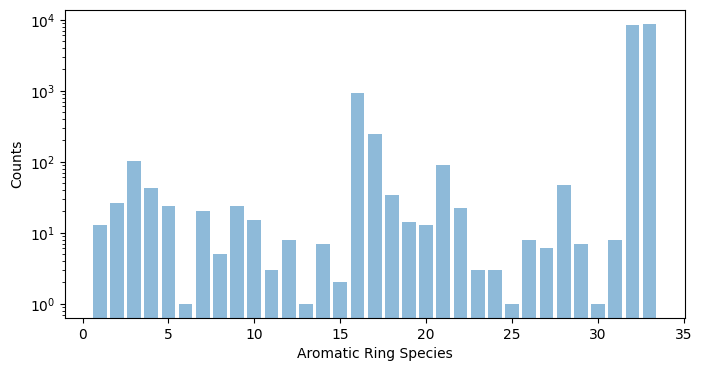

In [49]:
# feats.sum()
# plot the most frequent aromatic ring counts
plt.figure(figsize=(8,4))
x = []
counts = []
idx = 0
for key, count in feats.sum().items():
    if key == 'aromatic' or count < 1 or 'aromatic_' not in key:
        continue
    idx += 1
    x.append(idx)
    counts.append(count)
plt.bar(x, counts, alpha=0.5)
plt.yscale('log')
plt.xlabel('Aromatic Ring Species')
plt.ylabel('Counts')

In [41]:
feats

,aromatic,aromatic_furan,aromatic_pyrrole,aromatic_thiophene,aromatic_imidazole,aromatic_pyrazole,aromatic_isoxazole,aromatic_thiazole,aromatic_benzofuran,aromatic_indole,...,ring_bonds,aromatic_atoms,aromatic_bonds,conjugated_bonds,rotatable_bonds,FpDensityMorgan3,FractionCSP3,MolLogP,MolMR,TPSA
0,2,0,0,0,0,0,0,0,0,0,...,15,12,12,13,0,1.866667,0.076923,4.78280,70.0840,0.00
0,1,0,0,0,0,0,0,0,0,0,...,6,6,6,6,1,3.111111,0.166667,2.91502,44.3740,12.89
0,2,0,0,0,0,0,0,0,0,0,...,15,12,12,16,0,1.687500,0.000000,4.42300,70.7105,17.07
0,1,0,0,0,0,0,0,0,0,0,...,6,6,6,6,0,3.000000,0.000000,2.60660,39.6370,12.89
0,1,0,0,0,0,0,0,0,0,0,...,6,6,6,6,1,3.000000,0.142857,3.52002,46.5790,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2,0,0,0,0,0,0,0,0,0,...,16,12,12,18,0,1.666667,0.000000,3.04760,71.5290,59.92
0,2,0,0,0,0,0,0,0,0,0,...,10,9,10,10,12,2.160000,0.666667,7.01130,104.6180,30.71
0,5,0,1,0,0,0,0,0,0,2,...,15,13,15,17,3,2.250000,0.133333,4.79420,87.0968,42.23
0,1,0,0,0,0,0,0,0,0,0,...,6,6,6,8,1,2.818182,0.000000,3.16320,47.1875,17.07


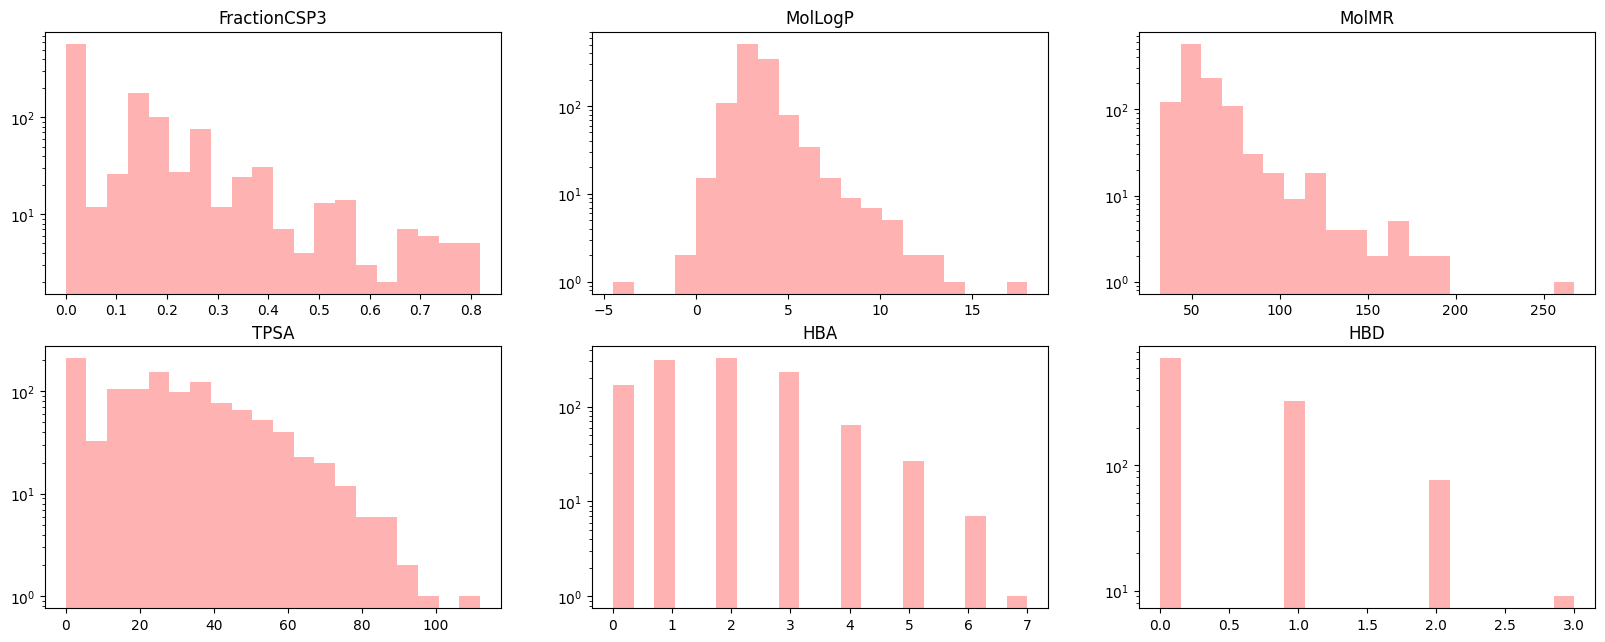

In [53]:
# plot feature distributions
feats_tmp = feats[feats.columns[-6:]]
# feats_tmp = feats
fig = plt.figure(figsize=(20, 32))
for i, (col, data) in enumerate(feats_tmp.items()):
    ax = fig.add_subplot(8, 3, i+1)
    ax.hist(data, bins=20, alpha=0.3, color='red')
    # ax.set_ylim(0, 1200)
    ax.set_yscale('log')
    ax.set_title(col)

In [200]:
import seaborn as sns

<Axes: >

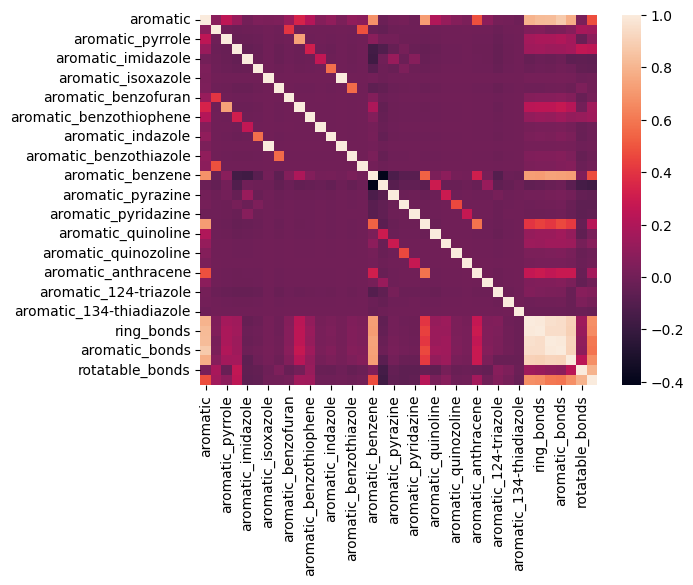

In [204]:
# plt.figure(figsize=(10, 10))
sns.heatmap(feats.corr(), annot=False)